In [1]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('./mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


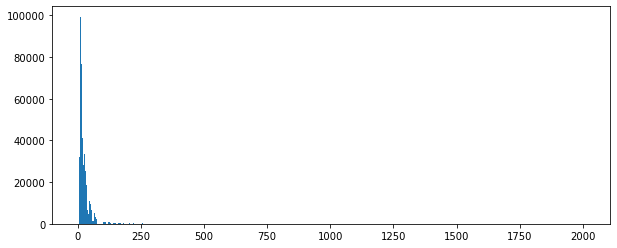

In [3]:
# It is very important to see the distribution of target value in case of regression
# For classification, it is also important to see the imbalance of dataset

# If skewed: 
# 1) Regression - Scaling(log scale, or min-max scale) + outlier value correction 
# 2) Classification - oversampling, SMOTE, 
#    + cost fuction revise to have more cost if prediction for imbalanced target value is wrong 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(10,4))
# sns.histplot(y_train_df)
plt.bar(y_train_df.value_counts().sort_index().index, y_train_df.value_counts().sort_index())
plt.show()

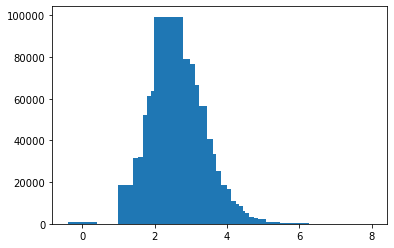

In [4]:
# Normalize target value
import numpy as np

y_train_df = np.log1p(y_train_df)
plt.bar(y_train_df.value_counts().sort_index().index, y_train_df.value_counts().sort_index())
plt.show()

In [5]:
# Conduct scaling
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [18]:
mercari_df[mercari_df['item_description'] == 'No description yet']['item_description'].count()

82489

In [21]:
## if you want to use apply lambda function with creating multiple return values
## You should consider using zip function. By using zip function with *, so zip(* /// ) makes something like
## zip file and can be unzipped into multiple values
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    


mercari_df['cat_dae'], mercari_df['cat_joong'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

In [29]:
## len + value_counts() == .nunique()
print(len(mercari_df['cat_joong'].value_counts()), mercari_df['cat_joong'].nunique())

print(len(mercari_df['cat_so'].value_counts()), mercari_df['cat_so'].nunique())

114 114
871 871


In [31]:
# drop category_name, as I already divided values into three different columns
mercari_df.drop('category_name', axis=1, inplace=True)

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

In [33]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
brand_name           632682
price                     0
shipping                  0
item_description          4
cat_dae                   0
cat_joong                 0
cat_so                    0
dtype: int64

In [34]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [36]:
mercari_df.isnull().sum().sum()

0

### Feature encoding & vectorization 

In [40]:
len(mercari_df['brand_name'].value_counts())

4810

In [41]:
mercari_df['brand_name'].value_counts()[:10]

Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Apple                 17322
FOREVER 21            15186
Nintendo              15007
Lululemon             14558
Michael Kors          13928
Name: brand_name, dtype: int64

In [43]:
len(mercari_df['name'].value_counts())

1225273

In [44]:
mercari_df['name'].value_counts()[:10]

Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64

In [52]:
# to know length of value, use .str.len()
mercari_df['item_description'].str.len().mean()

145.7113889385411

In [60]:
len(mercari_df['item_description'].value_counts())

1281427

In [57]:
# 별건아니고, 메모리 확보용 펑션
# import gc
# gc.collect()

15

## Name: Count, Item_description: Tf-idf 

In [59]:
# We can just run one-hot encoding, but...it seems that we can also vectorize values into given max_features

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df['name'])

tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

X_name.shape, X_descp.shape

((1482535, 30000), (1482535, 50000))

In [61]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   brand_name         1482535 non-null  object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482535 non-null  object 
 7   cat_dae            1482535 non-null  object 
 8   cat_joong          1482535 non-null  object 
 9   cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 113.1+ MB


In [67]:
# What would you do if dataset is somewhat like below?
# train_id: 1482535 -> will delete, so doesn't matter

# name: 1225273 
# -> What I did previously: just keep say top 20, and merge others into others
# -> big issue and one-hot encoding? so maybe using SVM and get only few values
# -> if it is a categorical data, and has meanings, then why not use NLP? -> Count              

# item_condition_id: 5 -> one-hot encoding
# brand_name: 4810 ?
# price: 828 -> target value
# shipping: 2 -> one-hot encoding

# item_description: 1281427
# Same issue, but this has more decription, and that means using tf-idf is more efficient

# cat_dae: 11 -> one-hot encoding
# cat_joong: 114 ?
# cat_so: 871 ?

print('train_id:', len(mercari_df['train_id'].value_counts()))
print('name:', len(mercari_df['name'].value_counts()))
print('item_condition_id:', len(mercari_df['item_condition_id'].value_counts()))
print('brand_name:', len(mercari_df['brand_name'].value_counts()))
print('price:', len(mercari_df['price'].value_counts()))
print('shipping:', len(mercari_df['shipping'].value_counts()))
print('item_description:', len(mercari_df['item_description'].value_counts()))
print('cat_dae:', len(mercari_df['cat_dae'].value_counts()))
print('cat_joong:', len(mercari_df['cat_joong'].value_counts()))
print('cat_so:', len(mercari_df['cat_so'].value_counts()))

train_id: 1482535
name: 1225273
item_condition_id: 5
brand_name: 4810
price: 828
shipping: 2
item_description: 1281427
cat_dae: 11
cat_joong: 114
cat_so: 871


In [69]:
# If we were to use NLP, then use LabelBinarizer instead of get_dummies
from sklearn.preprocessing import LabelBinarizer

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_joong = LabelBinarizer(sparse_output=True)
X_cat_joong = lb_cat_joong.fit_transform(mercari_df['cat_joong'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [70]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print(X_brand.shape, X_item_cond_id.shape, X_shipping.shape, X_cat_dae.shape, X_cat_joong.shape, X_cat_so.shape)

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
(1482535, 4810) (1482535, 5) (1482535, 1) (1482535, 11) (1482535, 114) (1482535, 871)


In [78]:
# from scipy.sparse import hstack
# import gc

# sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_joong, X_cat_so)

# # csr matrix 상태를 유지하면서 hstack으로 쭉 합친다. 
# X_features_sparse = hstack(sparse_matrix_list).tocsr()
# type(X_features_sparse), X_features_sparse.shape

# del X_features_sparse

In [84]:
# Defining Cost Function
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    
    return rmsle_result

In [82]:
from scipy.sparse import hstack
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import gc

def model_train_predict(model, matrix_list):
    
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.3, random_state=0)
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test    

In [ ]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)

print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

In [85]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_joong, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('1st:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_joong, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('2nd:', evaluate_org_price(y_test, linear_preds))


1st: 0.5028493714712275
2nd: 0.4703082873424784


In [86]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_joong, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=0)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('3rd:', evaluate_org_price(y_test, lgbm_preds))

3rd: 0.4572554183552044


In [87]:
# Combined version(in terms of regression, we can kind of combine models )
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('4th', evaluate_org_price(y_test, preds))

4th 0.4498832275001616
